In [88]:
import json
from pathlib import Path

import numpy as np
from tqdm import tqdm

In [118]:
files = Path("../logs/changes/").glob("nodes-256-seed-*-correction-none.jsonl")


train_changes = []
aggregation_changes = []
total_changes = []
scs = []

sigma_ans = []
sigma_aps = []

p = "fc1.weight"

for fn in tqdm(list(files)):
    with open(fn) as f:
        this_train_changes = []
        this_aggregation_changes = []
        this_total_changes = []
        this_scs = []

        this_sigma_aps = []
        this_sigma_ans = []
        for l in f:
            j = json.loads(l)

            this_sigma_ans.append(np.mean(j["stds_across_nodes"][p]["data"]))
            this_sigma_aps.append(np.mean([c[p] for c in j["stds_across_params"].values()]))

            
            if j["round"] > 0:
                tr = 0
                for c in j["training_changes"].values():
                    tr += np.linalg.norm(c[p]["data"])
                tr /= len(j["training_changes"])
                this_train_changes.append(tr)
    
                ag = 0
                for c in j["aggregation_changes"].values():
                    ag += np.linalg.norm(c[p]["data"])
                ag /= len(j["aggregation_changes"])
                this_aggregation_changes.append(ag)

                sc = 0
                total = 0
                for c1, c2 in zip(j["training_changes"].values(), j["aggregation_changes"].values()):
                    a =  np.array(c1[p]["data"])
                    b= np.array(c2[p]["data"])
                    total += np.linalg.norm(a + b)
                    sc += np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
                total /= len(j["aggregation_changes"])
                sc /= len(j["aggregation_changes"])
                this_total_changes.append(total)
                this_scs.append(sc)

    train_changes.append(this_train_changes + [np.nan]*(24-len(this_train_changes)))
    aggregation_changes.append(this_aggregation_changes + [np.nan]*(24-len(this_aggregation_changes)))
    total_changes.append(this_total_changes + [np.nan]*(24-len(this_total_changes)))
    scs.append(this_scs + [np.nan]*(24-len(this_scs)))
    
    sigma_ans.append(this_sigma_ans + [np.nan]*(25-len(this_sigma_ans)))
    sigma_aps.append(this_sigma_aps + [np.nan]*(25-len(this_sigma_aps)))

100%|██████████| 6/6 [01:21<00:00, 13.54s/it]


In [119]:
print([len(i) for i in train_changes])

[24, 24, 24, 24, 24, 24]


In [184]:
import networkx as nx

def simulate(
        nodes=256, k=32, noise=1e-8, params=200, rounds=25, gain=1.0,
        bounds=5.0, network_type="regular"):
    state = np.random.uniform(-bounds*gain, +bounds*gain, size=(nodes, params))

    if network_type == "regular":
        net = nx.random_regular_graph(d=k, n=nodes)
        while not nx.is_connected(net):
            net = nx.random_regular_graph(d=k, n=nodes)
    elif network_type == "erdos":
        p = k/(nodes-1)
        net = nx.fast_gnp_random_graph(p=p, n=nodes)
        while not nx.is_connected(net):
            net = nx.fast_gnp_random_graph(p=p, n=nodes)
    elif network_type == "ba":
        while not nx.is_connected(net := nx.barabasi_albert_graph(
                m=k//2, n=nodes)):
            pass
    elif network_type == "heavy":
        while not nx.is_connected(ba := nx.barabasi_albert_graph(
                m=k//2, n=nodes)):
            pass
        ds = [d for _, d in nx.degree(ba)]
        while not nx.is_connected(net := nx.expected_degree_graph(
                ds, selfloops=False)):
            pass

    elif network_type == "cycle":
        net = nx.empty_graph()
        ns = list(range(nodes))
        net.add_nodes_from(ns)
        for j in range(1, k // 2 + 1):
            targets = ns[j:] + ns[0:j]
            net.add_edges_from(zip(ns, targets))
    elif network_type == "lattice":
        side = int(nodes**0.5)
        net = nx.grid_graph((side, side), periodic=True)
    elif network_type == "partition":
        partition_size = nodes//2
        k_out = k/64
        p_out = k_out/partition_size
        k_in = k - k/64
        p_in = k_in/(partition_size - 1)
        while not nx.is_connected(net :=  nx.random_partition_graph(
                sizes=(partition_size,)*2, p_in=p_in, p_out=p_out)):
            pass
    else:
        raise NotImplementedError(f"network type ``{network_type}'' is not implemented")

    adj = nx.to_scipy_sparse_array(net, format="lil")
    for i in range(nodes):
        adj[i, i] = 1

    initial_stds = np.std(state, axis=1)[:, np.newaxis]

    adj /= np.sum(adj, axis=1)[:, np.newaxis]
    noise = stats.norm(loc=0, scale=noise)

    stds_across_nodes = []
    stds_across_params = []

    for i in range(rounds):
        stds_across_nodes.append(np.mean(np.std(state, axis=0)))
        stds_across_params.append(np.mean(np.std(state, axis=1)))

        state = adj @ state + noise.rvs(state.shape)
    return stds_across_nodes, stds_across_params

In [204]:
noise = 1e-8
bounds = (np.nanmean(sigma_aps, axis=0)*np.sqrt(n)*np.sqrt(12)/2)[-1]
n = 256
k = 32
sim_stds_across_nodes = []
sim_stds_across_params = []

for i in range(5):
    san, sap = simulate(nodes=n, k=k, noise=noise, bounds=bounds, rounds=25)
    sim_stds_across_nodes.append(san)
    sim_stds_across_params.append(sap)

Text(-0.1, 1.05, '(c)')

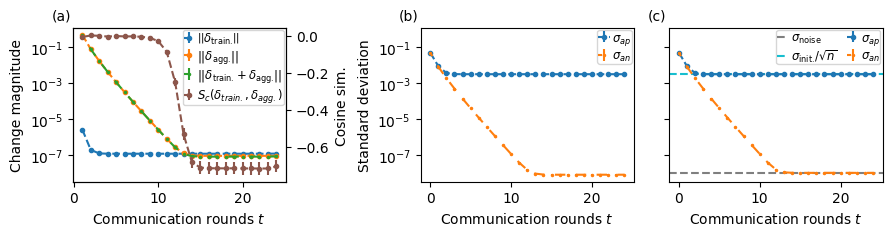

In [260]:
import matplotlib.pyplot as plt
from scipy import stats

fig, (ax_diff, dummy, ax_sigma, ax_sim) = plt.subplots(
    ncols=4, nrows=1, figsize=(8.1, 2.0),
    sharey="row",
    gridspec_kw={"left": 0, "right": 1, "wspace": 0.2, "hspace": 0.45, "width_ratios": [1, 0.3, 1, 1]})
dummy.set_visible(False)


ax_sc = ax_diff.twinx()

l1 = ax_diff.errorbar(range(1, 25), np.nanmean(train_changes, axis=0),
             yerr=1.96*np.nanstd(train_changes, axis=0)/np.sum(~np.isnan(train_changes), axis=0)**0.5,
             label="$\\left|\\left|\\delta_\\text{train.}\\right|\\right|$", ls="--", marker=".")
l2 = ax_diff.errorbar(range(1, 25), np.nanmean(aggregation_changes, axis=0),
             yerr=1.96*np.nanstd(aggregation_changes, axis=0)/np.sum(~np.isnan(aggregation_changes), axis=0)**0.5,
             label="$\\left|\\left|\\delta_\\text{agg.}\\right|\\right|$", ls="--", marker=".")
l3 = ax_diff.errorbar(range(1, 25), np.nanmean(total_changes, axis=0),
             yerr=1.96*np.nanstd(total_changes, axis=0)/np.sum(~np.isnan(total_changes), axis=0)**0.5,
             label="$\\left|\\left|\\delta_\\text{train.}+\\delta_\\text{agg.}\\right|\\right|$", ls=(3, (5, 5)), marker=".", ms=3)
ax_diff.set_yscale("log")

ax_diff.set_xlabel("Communication rounds $t$")
ax_diff.set_ylabel("Change magnitude")

l4 = ax_sc.errorbar(range(1, 25), np.nanmean(scs, axis=0),
               yerr=1.96*np.nanstd(scs, axis=0)/np.sum(~np.isnan(scs), axis=0)**0.5,
               label="$S_c(\\delta_{train.}, \\delta_{agg.})$", color="tab:brown", ls="--", marker=".")
ax_sc.set_ylabel("Cosine sim.")


ax_sc.set_yscale("linear")

lns = [l1, l2, l3, l4]
labs = [l.get_label() for l in lns]

ax_sc.legend(lns, labs, fontsize="small", ncols=1, borderpad=0.05, labelspacing=0.2,
             handlelength=1.0, handletextpad=0.2, borderaxespad=0.2,
             columnspacing=0.8)

# ax_sc.set_xlim(0, 27)


ax_sigma.errorbar(range(25), np.nanmean(sigma_aps, axis=0),
             yerr=1.96*np.nanstd(sigma_aps, axis=0)/np.sum(~np.isnan(sigma_aps), axis=0)**0.5,
             label="$\\sigma_{ap}$", ls="--", marker=".")
ax_sigma.errorbar(range(25), np.nanmean(sigma_ans, axis=0),
             yerr=1.96*np.nanstd(sigma_ans, axis=0)/np.sum(~np.isnan(sigma_ans), axis=0)**0.5,
             label="$\\sigma_{an}$", ls=(3, (5, 5)), marker=".", ms=3)
ax_sigma.legend(fontsize="small", ncols=1, borderpad=0.05, labelspacing=0.2,
            handlelength=1.0, handletextpad=0.2, borderaxespad=0.2,
            columnspacing=0.8)
ax_sigma.set_xlabel("Communication rounds $t$")
ax_sigma.set_ylabel("Standard deviation")
ax_sigma.yaxis.set_tick_params(labelleft=True)

ax_sim.set_xlabel("Communication rounds $t$")
ax_sim.errorbar(range(25), np.nanmean(sim_stds_across_params, axis=0),
             yerr=1.96*np.nanstd(sim_stds_across_params, axis=0)/np.sum(~np.isnan(sim_stds_across_params), axis=0)**0.5,
             label="$\\sigma_{ap}$", ls="--", marker=".")
ax_sim.errorbar(range(25), np.nanmean(sim_stds_across_nodes, axis=0),
             yerr=1.96*np.nanstd(sim_stds_across_nodes, axis=0)/np.sum(~np.isnan(sim_stds_across_nodes), axis=0)**0.5,
             label="$\\sigma_{an}$", ls=(3, (5, 5)), marker=".", ms=3)

sigma_init = np.sqrt(1/12)*2*bounds
ax_sim.axhline(noise, ls='--', color='tab:gray', label="$\\sigma_\\text{noise}$")
ax_sim.axhline(sigma_init/np.sqrt(n), ls='--', color='tab:cyan', label="$\\sigma_\\text{init.}/\\sqrt{n}$")

ax_sim.legend(fontsize="small", ncols=2, borderpad=0.05, labelspacing=0.2,
            handlelength=1.0, handletextpad=0.2, borderaxespad=0.2,
            columnspacing=0.8)

ax_diff.text(-0.1, 1.05, "(a)",
         transform=ax_diff.transAxes)
ax_sigma.text(-0.1, 1.05, "(b)",
         transform=ax_sigma.transAxes)
ax_sim.text(-0.1, 1.05, "(c)",
         transform=ax_sim.transAxes)

In [261]:
fig.savefig("changes.pdf", bbox_inches="tight")